<a href="https://colab.research.google.com/github/freud-sensei/imfine_torch/blob/main/%5B%EB%B1%80%EA%B3%BC%ED%9A%83%EB%B6%88%5D_%EC%86%90%EA%B8%80%EC%94%A8_%EC%88%AB%EC%9E%90_%EC%9D%B4%EB%AF%B8%EC%A7%80_%EB%B6%84%EB%A5%98.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 모듈 및 분석환경 설정

## 모듈 불러오기

In [ ]:
import torch
import torch.nn as nn # 네트워크의 구성요소
import torch.nn.functional as F # 각종 함수
import torch.optim as optim # 최적화 알고리즘
from torchvision import datasets, transforms # 이미지 데이터셋 및 변환 기술
import matplotlib.pyplot as plt # 이건 뭔지 알죠?

## 분석 환경 설정

In [ ]:
is_cuda = torch.cuda.is_available()
device = torch.device('cuda' if is_cuda else 'cpu')
print('Current cuda device is', device)

Current cuda device is cuda


## Hyperparameter 지정

In [ ]:
batch_size = 50 # 미니배치 사이즈: 가중치를 1번 업데이트시킬 때 사용하는 샘플 수
epoch_num = 15 # Epoch 수: 학습데이터를 모두 사용하여 학습하는 기본 단위 수
learning_rate = 0.0001 # 학습률: 가중치 업데이트 정도

# 데이터 불러오기

## MNIST 데이터 불러오기

In [ ]:
train_data = datasets.MNIST(root='./data', train=True, download=True, transform=transforms.ToTensor())
test_data = datasets.MNIST(root='./data', train=False, transform=transforms.ToTensor())
print(len(train_data), len(test_data))

100%|██████████| 9912422/9912422 [00:00<00:00, 240860834.61it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 25950234.32it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 86840510.26it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 7450343.67it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

60000 10000


## MNIST 데이터 확인하기

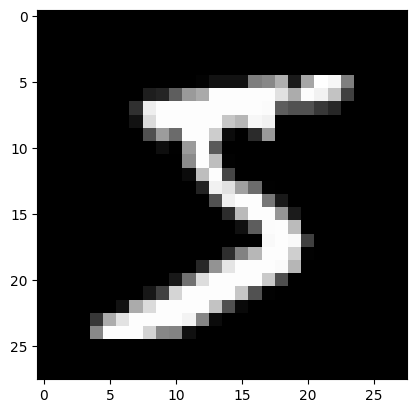

In [ ]:
image, label = train_data[0]
plt.imshow(image.squeeze().numpy(), cmap='gray') # squeeze: 길이가 1인 차원을 모두 없앤다. [1, 28, 28] -> [28, 28]
plt.show()

## 미니배치 구성하기

In [ ]:
train_loader = torch.utils.data.DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_data, batch_size=batch_size, shuffle=True)
# 시계열 데이터가 아닌 이상, 데이터의 순서에 대해서 학습하지 못하게 섞어 주는 것이 기본

first_batch = train_loader.__iter__().__next__()
print(len(train_loader)) # 1200: 60000(학습 데이터) / 50(batch size) = 1200
print(str(type(first_batch)), len(first_batch))
print(str(type(first_batch[0])), first_batch[0].shape) # [batch size, channel, width, height]
print(str(type(first_batch[1])), first_batch[1].shape)

1200
<class 'list'> 2
<class 'torch.Tensor'> torch.Size([50, 1, 28, 28])
<class 'torch.Tensor'> torch.Size([50])


# CNN 모델 학습

## CNN 구조 설계하기

In [ ]:
class CNN(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(1, 32, 3, 1) # in_chanels(필터의 depth), out_channels(필터의 수), kernel(필터의 크기), stride
    self.conv2 = nn.Conv2d(32, 64, 3, 1)
    self.dropout1 = nn.Dropout(0.25) # 0.25 확률의 dropout
    self.dropout2 = nn.Dropout2d(0.5)
    self.fc1 = nn.Linear(9216, 128)
    self.fc2 = nn.Linear(128, 10)

  def forward(self, x):
    x = self.conv1(x)
    x = F.relu(x)
    x = self.conv2(x)
    x = F.relu(x)
    x = F.max_pool2d(x, 2) # pooling은 단순 연산, 학습가중치가 없음
    x = self.dropout1(x)
    x = torch.flatten(x, 1) # 1차원 텐서로 변환. 이 경우 dim 0만 유지, dim 1~-1까진 flatten
    x = self.fc1(x)
    x = F.relu(x)
    x = self.dropout2(x)
    x = self.fc2(x)
    output = F.log_softmax(x, dim=1)
    return output

## 옵티마이저 및 손실함수 정의

In [ ]:
model = CNN().to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss() # 다중 클래스 분류 -> 교차엔트로피

## 설계한 모형 확인하기

In [ ]:
print(model)

CNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (dropout1): Dropout(p=0.25, inplace=False)
  (dropout2): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=9216, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)


## 모델 학습

In [ ]:
model.train() # 학습 모드로 실행 (이것만 실행한다고 훈련되는 건 아님)
i = 0

for epoch in range(epoch_num):
  for data, target in train_loader:
    data = data.to(device)
    target = target.to(device)
    optimizer.zero_grad() # 이전 반복시행에서 저장된 optimizer의 gradient 초기화
    output = model(data) # 순전파
    loss = criterion(output, target) # 손실함수 계산
    loss.backward() # 역전파 -> gradient 계산
    optimizer.step() # 가중치 없데이트
    if i % 1000 == 0:
      print(f"Train Step: {i}\tLoss: {loss.item():.3f}")
    i += 1

Train Step: 0	Loss: 2.297
Train Step: 1000	Loss: 0.278
Train Step: 2000	Loss: 0.175
Train Step: 3000	Loss: 0.153
Train Step: 4000	Loss: 0.125
Train Step: 5000	Loss: 0.073
Train Step: 6000	Loss: 0.129
Train Step: 7000	Loss: 0.196
Train Step: 8000	Loss: 0.032
Train Step: 9000	Loss: 0.155
Train Step: 10000	Loss: 0.055
Train Step: 11000	Loss: 0.416
Train Step: 12000	Loss: 0.008
Train Step: 13000	Loss: 0.057
Train Step: 14000	Loss: 0.033
Train Step: 15000	Loss: 0.065
Train Step: 16000	Loss: 0.104
Train Step: 17000	Loss: 0.026


# 모델 평가

In [ ]:
model.eval() # 평가모드: dropout이 적용되지 않으며, batch normalization도 평가모드로 전환
correct = 0

for data, target in test_loader:
  data = data.to(device)
  target = target.to(device)
  output = model(data)
  prediction = output.max(axis=1)[1] # [0]에는 max 값이, [1]에는 index가 위치
  correct += (prediction == target).sum() # 정답은 True, 오답은 False인 논리값의 벡터

accuracy = 100 * (correct / len(test_loader.dataset))
print(f"Test set: Accuracy: {accuracy:.2f}%")

Test set: Accuracy: 98.96%


# 정리

**파이토치 프로그래밍의 절차**
1. **Dataset**을 만들고 **DataLoader**에 불러와 미니배치를 구성한다. `torch.utils.data.DataLoader(...)`

2. **모형**을 정의한다. `class 아무개(nn.Module):`

3. **옵티마이저와 손실함수**를 정의한다. `torch.nn`, `torch.optim`

4. 모델을 **학습**한다. (`optimizer.zero_grad()` -> output 및 loss 계산 -> `loss.backward()` -> `optimizer.step()`)

5. 모델을 **평가**한다.

+ 너가 GPU를 쓰고 싶다...? 그러면 **model, data, target** 3개에 `.to(device)` 등으로 처리를 해 줘야 한다.